In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.metrics import classification_report, confusion_matrix


In [25]:
DATA_DIR   = "../DATA/RealWaste"
OUTPUT_DIR = "../OUTPUT"
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE   = (160, 160)   # smaller than 224 -> faster
BATCH_SIZE = 32
SEED      = 42
EPOCHS    = 8             # small to start; we can increase later


In [27]:
# 80% train, 10% val, 10% test (via two calls)
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=SEED
)

# Make a test set by splitting the validation dataset in half
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds  = val_ds.skip(val_batches // 2)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)
print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())


Found 4752 files belonging to 9 classes.
Using 3802 files for training.
Found 4752 files belonging to 9 classes.
Using 950 files for validation.
Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Train batches: 119
Val batches: 15
Test batches: 15


In [29]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


In [31]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ]
)

def build_small_cnn(input_shape=IMG_SIZE + (3,), num_classes=9):
    inputs = layers.Input(shape=input_shape)
    
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)
    
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs)
    return model

model = build_small_cnn(num_classes=num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 160, 160, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 80, 80, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 80, 80, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 40, 40, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 40, 40, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/8
119/119 ━━━━━━━━━━━━━━━━━━━━ 25s 192ms/step - accuracy: 0.2688 - loss: 2.0148 - val_accuracy: 0.3872 - val_loss: 1.6872
Epoch 2/8
119/119 ━━━━━━━━━━━━━━━━━━━━ 23s 181ms/step - accuracy: 0.3898 - loss: 1.6919 - val_accuracy: 0.4319 - val_loss: 1.8421
Epoch 3/8
119/119 ━━━━━━━━━━━━━━━━━━━━ 23s 184ms/step - accuracy: 0.4492 - loss: 1.5370 - val_accuracy: 0.4936 - val_loss: 1.4386
Epoch 4/8
119/119 ━━━━━━━━━━━━━━━━━━━━ 24s 187ms/step - accuracy: 0.4790 - loss: 1.4318 - val_accuracy: 0.5043 - val_loss: 1.4163
Epoch 5/8
119/119 ━━━━━━━━━━━━━━━━━━━━ 24s 188ms/step - accuracy: 0.5074 - loss: 1.3619 - val_accuracy: 0.5362 - val_loss: 1.4418
Epoch 6/8
119/119 ━━━━━━━━━━━━━━━━━━━━ 24s 192ms/step - accuracy: 0.5334 - loss: 1.2969 - val_accuracy: 0.5170 - val_loss: 1.4016
Epoch 7/8
119/119 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.5429 - loss: 1.2490 - val_accuracy: 0.5574 - val_loss: 1.2879
Epoch 8/8
119/119 ━━━━━━━━━━━━━━━━━━━━ 24s 188ms/step - accuracy: 0.5573 - loss: 1.2047 - 

In [34]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5396 - loss: 1.3148
Test accuracy: 0.540


In [35]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


In [36]:
print(classification_report(
    y_true, y_pred,
    target_names=class_names,
    digits=4
))


                     precision    recall  f1-score   support

          Cardboard     0.4783    0.5641    0.5176        39
      Food Organics     0.4531    0.7436    0.5631        39
              Glass     0.6250    0.4167    0.5000        36
              Metal     0.5889    0.5955    0.5922        89
Miscellaneous Trash     0.3333    0.1273    0.1842        55
              Paper     0.5526    0.6885    0.6131        61
            Plastic     0.5745    0.6136    0.5934        88
      Textile Trash     0.6154    0.1951    0.2963        41
         Vegetation     0.5192    0.8438    0.6429        32

           accuracy                         0.5354       480
          macro avg     0.5267    0.5320    0.5003       480
       weighted avg     0.5327    0.5354    0.5111       480



Saved confusion matrix to: ../OUTPUT\cm_small_cnn.png


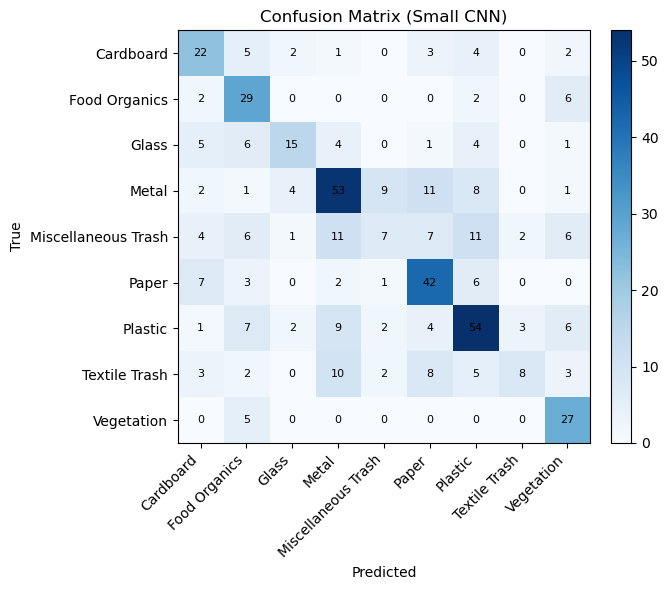

In [37]:
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks(range(num_classes))
ax.set_yticks(range(num_classes))
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticklabels(class_names)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix (Small CNN)")

for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=8)

plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()

cm_path = os.path.join(OUTPUT_DIR, "cm_small_cnn.png")
plt.savefig(cm_path, dpi=300, bbox_inches="tight")
print("Saved confusion matrix to:", cm_path)

plt.show()
